In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
!nvidia-smi

Found GPU at: /device:GPU:0
Fri Aug 28 10:55:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    31W / 250W |    359MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv3D, MaxPooling3D, merge, AveragePooling3D, Dropout, Flatten, Activation
from keras.utils import to_categorical
from tensorflow.keras import regularizers
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
import tensorflow as tf
import os
import warnings
import keras.models as KM
from tensorflow.keras.losses import categorical_crossentropy

In [3]:
unpickled_df1 = pd.read_pickle("../input/5k-infinite/train_set_infinite.pkl")
unpickled_df2 = pd.read_pickle("../input/5k-infinite/valid_set_infinite.pkl")

X_train_df = unpickled_df1["subtom"][:]
Y_train_df = unpickled_df1["label"][:]
X_val_df=unpickled_df2["subtom"][:]
Y_val_df=unpickled_df2["label"][:]
print(X_train_df[0].shape)

(32, 32, 32)


In [4]:

#Xtrain Ytrain
l1=[]
for i in range(4000):
    l1.append(X_train_df[i])
X_train=np.array(l1)
X_train = X_train.reshape(X_train.shape[0], 32, 32, 32 , 1)
print(X_train.shape)
l2=[]
for i in range(4000):
    l2.append(Y_train_df[i])
y_train=np.array(l2)
classes=10
Y_train = np_utils.to_categorical(y_train, classes)#onehotencode
print(Y_train.shape)

#Xval,Yval
m1=[]
for i in range(1000):
    m1.append(X_val_df[i])
X_val=np.array(m1)
X_val = X_val.reshape(X_val.shape[0], 32, 32, 32 , 1)
print(X_val.shape)#4000x32x32x32x1
m2=[]
for i in range(1000):
    m2.append(Y_val_df[i])
y_val=np.array(m2)
classes=10
Y_val = np_utils.to_categorical(y_val, classes)#onehotencode
print(Y_val.shape)
from sklearn.utils import shuffle
X_train, Y_train = shuffle(X_train, Y_train)
X_val, Y_val = shuffle(X_val, Y_val)


(4000, 32, 32, 32, 1)
(4000, 10)
(1000, 32, 32, 32, 1)
(1000, 10)


In [5]:
tf.keras.regularizers.l2(l2=0.01)


In [14]:
#model

input_layer = Input((32, 32, 32, 1))
input = Input(shape = (32, 32, 32, 1), name='input')

m = Conv3D(32,(3, 3, 3), activation="relu", padding="same", name="conv1")(input)
m = BatchNormalization(name="bnorm1")(m)
# m = Dropout(0.1)(m)
m = Conv3D(32,(3, 3, 3), activation="relu", padding="same", name="conv2")(m)
m = BatchNormalization(name="bnorm11")(m)
m = MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), name='maxpool1')(m)
# m = Dropout(0.1)(m)

m = Conv3D(64,(3, 3, 3), activation="relu", padding="same", name="conv3")(m)
m = BatchNormalization(name="bnorm2")(m)
# m = Dropout(0.1)(m)
m = Conv3D(64,(3, 3, 3), activation="relu", padding="same", name="conv4")(m)
m = BatchNormalization(name="bnorm21")(m)
m = MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), name='maxpool2')(m)
# m = Dropout(0.1)(m)




m = Flatten(name='flatten')(m)
m = Dense(512, activation='relu', name='fc1',kernel_regularizer='l2')(m)
m = Dropout(0.4)(m)
m = Dense(512, activation='relu', name='fc2',kernel_regularizer='l2')(m)
m = Dropout(0.4)(m)
m = Dense(10, activation='linear', name='fc3')(m)
m = Activation('softmax', name='softmax')(m)

model = KM.Model(inputs=input, outputs=m)


In [15]:
model.summary()
# keras.utils.plot_model(model, "my_first_model.png",show_shapes=True)

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 32, 32, 32, 1)]   0         
_________________________________________________________________
conv1 (Conv3D)               (None, 32, 32, 32, 32)    896       
_________________________________________________________________
bnorm1 (BatchNormalization)  (None, 32, 32, 32, 32)    128       
_________________________________________________________________
conv2 (Conv3D)               (None, 32, 32, 32, 32)    27680     
_________________________________________________________________
bnorm11 (BatchNormalization) (None, 32, 32, 32, 32)    128       
_________________________________________________________________
maxpool1 (MaxPooling3D)      (None, 16, 16, 16, 32)    0         
_________________________________________________________________
conv3 (Conv3D)               (None, 16, 16, 16, 64)   

In [16]:
from keras.callbacks import  EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["val_acc"]
        if val_acc >= self.threshold:
            self.model.stop_training = True
filepath = 'papercnninfinite.h5'
mcp = ModelCheckpoint(filepath,monitor='val_acc', mode='max', save_best_only=True, save_weights_only=True, verbose=1)
my_callback = MyThresholdCallback(threshold=0.90)
earlystop = EarlyStopping(monitor='val_loss',mode='min',patience=10,verbose=1,)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.4)

In [17]:
opt = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['acc'])
history=model.fit(x=X_train, y=Y_train, batch_size=70, epochs=125, verbose=1,callbacks=[learning_rate_reduction, my_callback], validation_data=(X_val,Y_val),shuffle=False)


Epoch 1/125
58/58 [==============================] - 13s 232ms/step - loss: 21.4364 - acc: 0.1163 - val_loss: 18.4606 - val_acc: 0.1310
Epoch 2/125
58/58 [==============================] - 13s 223ms/step - loss: 11.2807 - acc: 0.1155 - val_loss: 8.9986 - val_acc: 0.1160
Epoch 3/125
58/58 [==============================] - 13s 222ms/step - loss: 7.4799 - acc: 0.1417 - val_loss: 6.3333 - val_acc: 0.1440
Epoch 4/125
58/58 [==============================] - 13s 224ms/step - loss: 5.6316 - acc: 0.1500 - val_loss: 5.0582 - val_acc: 0.1490
Epoch 5/125
58/58 [==============================] - 13s 222ms/step - loss: 4.6993 - acc: 0.1558 - val_loss: 4.3968 - val_acc: 0.1660
Epoch 6/125
58/58 [==============================] - 13s 222ms/step - loss: 4.2075 - acc: 0.1692 - val_loss: 3.9756 - val_acc: 0.1860
Epoch 7/125
58/58 [==============================] - 13s 222ms/step - loss: 3.9034 - acc: 0.1650 - val_loss: 3.6273 - val_acc: 0.2150
Epoch 8/125
58/58 [==============================] - 13s 22

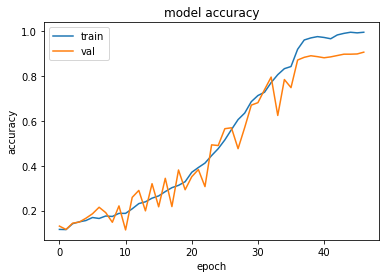

In [18]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

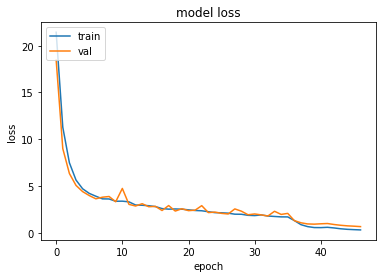

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
pred = model.predict(X_val)
pred = np.argmax(pred, axis=1)
pred

array([1, 2, 3, 6, 6, 0, 3, 6, 8, 7, 2, 7, 7, 4, 6, 4, 4, 6, 0, 6, 3, 9,
       9, 4, 6, 0, 5, 7, 3, 1, 9, 7, 6, 9, 4, 4, 9, 9, 6, 0, 4, 5, 4, 3,
       9, 2, 8, 2, 3, 1, 2, 3, 3, 8, 8, 2, 1, 4, 4, 7, 8, 7, 5, 0, 7, 9,
       8, 0, 9, 3, 4, 7, 2, 3, 2, 8, 6, 8, 6, 8, 5, 4, 5, 6, 9, 8, 6, 3,
       7, 1, 9, 4, 5, 2, 6, 3, 1, 4, 0, 0, 3, 3, 7, 4, 1, 6, 8, 6, 3, 1,
       9, 7, 8, 3, 8, 2, 3, 8, 5, 1, 9, 0, 2, 6, 0, 6, 9, 4, 8, 1, 1, 7,
       5, 3, 8, 6, 5, 9, 8, 0, 6, 8, 9, 7, 4, 6, 1, 6, 8, 1, 4, 7, 6, 1,
       1, 9, 6, 4, 9, 1, 5, 7, 7, 3, 5, 9, 4, 8, 6, 4, 1, 2, 2, 1, 0, 1,
       1, 8, 6, 9, 1, 1, 0, 0, 4, 3, 7, 6, 6, 0, 5, 4, 3, 0, 9, 0, 1, 5,
       9, 6, 6, 9, 9, 8, 3, 4, 6, 8, 0, 1, 3, 2, 3, 7, 4, 0, 9, 4, 5, 7,
       2, 5, 8, 6, 9, 4, 9, 2, 6, 2, 7, 4, 1, 1, 4, 2, 4, 5, 4, 8, 8, 3,
       3, 3, 0, 1, 5, 0, 9, 6, 4, 1, 9, 4, 2, 1, 0, 0, 3, 0, 5, 7, 1, 5,
       3, 6, 4, 1, 4, 2, 8, 4, 8, 5, 1, 9, 1, 9, 3, 6, 0, 9, 4, 3, 8, 4,
       6, 5, 9, 5, 7, 4, 5, 6, 9, 3, 5, 9, 6, 9, 1,

In [21]:
print("Evaluate on test data")
results = model.evaluate(X_val, Y_val)
print("test loss, test acc:", results)

Evaluate on test data
32/32 [==============================] - 1s 36ms/step - loss: 0.6543 - acc: 0.9060
test loss, test acc: [0.6542844772338867, 0.906000018119812]


In [22]:
model.save('papercnn_infinite.h5')

In [23]:
from tensorflow.keras.models import load_model
model1 = load_model('papercnn_infinite.h5')

In [24]:
print("Evaluate on test data")
results = model1.evaluate(X_val, Y_val)
print("test loss, test acc:", results)

Evaluate on test data
32/32 [==============================] - 1s 33ms/step - loss: 0.6543 - acc: 0.9060
test loss, test acc: [0.6542844772338867, 0.906000018119812]
